## Notebook description

### Dataset

| Column name           | Description |
| --------------------- | ----------- |
| company_id            | The unique identification of the company |
| group_id              | The company's sectors or industries      |
| is_consultancy        | The **label** column. 1 if the company is a consulting. Otherwise 0 otherwise |
| predicted_consultancy | We also have a previous tool that predicts the consultancy status |
| text                  | Some text extracted from the company's website |

In [1]:
import sys
sys.path.append("../")

In [2]:
import matplotlib.pyplot as plt

import os
import pandas as pd

import tensorflow as tf
from tensorboard.plugins import projector

from tqdm import tqdm
from src.data import correlation
from src.features import build_features
from src.models import embedding, evaluate
from src.tools.startup import settings
from src.tools import utils as tools_utils
from src.visualization import plot_data

2023-11-05 16:04:37.557586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 16:04:37.598607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-05 16:04:37.599416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 16:04:38.629958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-11-05 16:04:40 - Logger initialized


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [3]:
# Volumes
raw_folder = settings["volumes"]["raw"]
logs_folder = settings["volumes"]["logs"]
processed_folder = settings["volumes"]["processed"]

# Dataset
dataset_filename = 'nlp_data_scientist_challenge_dataset.csv'
dataset_filepath = os.path.join(raw_folder, dataset_filename)
text_column = 'text'
target_column = 'is_consultancy'
labels_mapping = settings['dataset']['label_mapping']

cleaned_dataset_filepath = os.path.join(
    processed_folder, 'dataset.csv')

# Embeddings
model_name = settings['embeddings']['model_name']
embeddings_folder = settings['embeddings']['folder']

# Tensorboard
tensorboard_logs = logs_folder
checkpoint_embeddings = os.path.join(
    tensorboard_logs, f"checkpoint_embeddings.ckpt")

metadata_columns = [
    'company_id',
    'group_id', 
    'is_consultancy',
    'is_consultancy_label',
    'predicted_consultancy',
    'predicted_consultancy_label',
    'lang', 
]

os.environ['SENTENCE_TRANSFORMERS_HOME'] = './.cache'

## Extract

In [4]:
df = pd.read_csv(dataset_filepath)

In [5]:
original_total_rows = df.shape[0]
print(f'Total rows {original_total_rows}')

df.shape

Total rows 792


(792, 5)

In [6]:
df.head()

,company_id,group_id,is_consultancy,predicted_consultancy,text
0,d2d78cb1fe31d2c8fb7cc84bb1cab3ef,654,0,0.0,Legal Disclaimer MICRO-ALGAE PRODUCTION FACILI...
1,defd325d9bfa59e9843c23da0b0c2d8c,414,0,0.0,Home What We Do Technology Products EktoTherix...
2,a29dda8947c86bd7206137744fa201ef,414,0,0.0,top of page HOME ABOUT ADVISORS NEWSLETTER IMP...
3,e99d0615faa5a5405519c3c5dedc24ab,521,1,0.0,Skip to content Ayruz Data Marketing: Data Dri...
4,ee1951864f9ed6812b5350ccb04ef83b,654,0,0.0,top of page HOME OUR STORY PRODUCTS SUPERPLANT...


## Transform

#### Drop duplicates

In [7]:
df = df \
    .drop_duplicates() \
    .reset_index(drop=True)

cleaned_rows = df.shape[0]

duplicated_rows = original_total_rows - cleaned_rows
print(f'There are {duplicated_rows} duplicated rows.')

There are 1 duplicated rows.


In [8]:
df['is_consultancy_label'] = df['is_consultancy'].map(labels_mapping)
df['predicted_consultancy_label'] = df['predicted_consultancy'] \
    .map(labels_mapping)

#### This step computes the following features:
- digits_number
- punctuations_number
- original text length
- cleaned text length
- cleaned text without stopwords length
- original text tokens number
- cleaned text tokens number
- cleaned text without stopwords tokens number
- original text length and cleaned text length difference
- original text length and cleaned text without stopwords length difference
- cleaned text length and cleaned text without stopwords length difference
- original text tokens number and cleaned text tokens number difference
- original text tokens number and cleaned text without stopwords tokens
    number difference
- original text tokens number and cleaned text without stopwords tokens
    number difference

In [9]:
df = build_features.compute_features(df, text_column)

2023-11-05 16:04:46 - Error when downloading stopwords for language et: No such file or directory: '/home/jovyan/nltk_data/corpora/stopwords/estonian'.
2023-11-05 16:04:46 - Loading et stop words from local file /data/raw/estonian-stopwords.txt
2023-11-05 16:04:46 - Cleaning da...
2023-11-05 16:04:46 - Done.
2023-11-05 16:04:46 - Cleaning de...
2023-11-05 16:04:46 - Done.
2023-11-05 16:04:46 - Cleaning en...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning es...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning et...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning fi...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning fr...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning hu...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning it...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning nl...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning pt...
2023-11-05 16:04:48 - Done.
2023-11-05 16:04:48 - Cleaning sv...
202

## Analysis

#### Check nulls

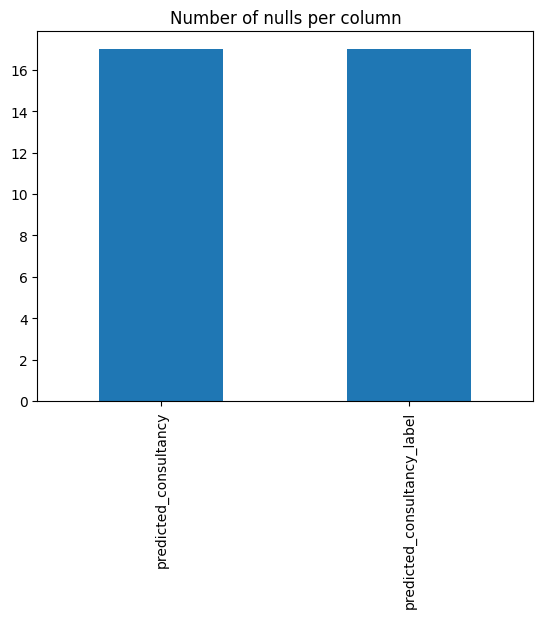

In [10]:
nulls_per_column = df \
    .isnull() \
    .sum() \
    .sort_values(ascending=False)

cond_gt_zero = nulls_per_column > 0
if not nulls_per_column[cond_gt_zero].empty:
    _ = nulls_per_column[cond_gt_zero] \
        .plot(kind='bar', title='Number of nulls per column')
else:
    print('There any any column with nulls')

In [11]:
for idx in nulls_per_column[nulls_per_column > 0].index:
    null_ratio_column = round(nulls_per_column[idx] / df.shape[0], 2)
    print(f"The column '{idx}' has {null_ratio_column * 100}% of nulls.")

The column 'predicted_consultancy' has 2.0% of nulls.
The column 'predicted_consultancy_label' has 2.0% of nulls.


#### Target column

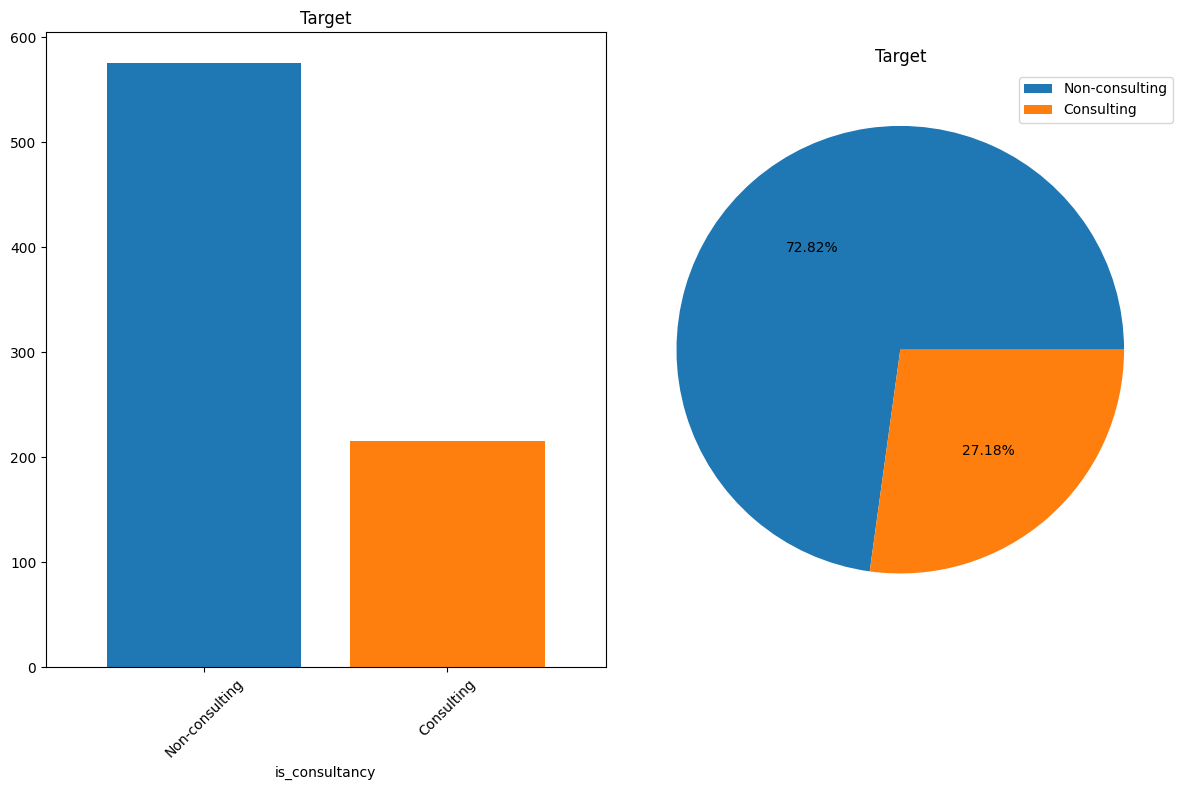

In [12]:
target_names = ["Non-consulting", "Consulting"]
color = ["tab:blue", "tab:orange"]

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.groupby(target_column).size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45, 
    legend=False, color=color)
ax1.set_xticklabels(target_names)

df.groupby(target_column).size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, autopct="%.2f%%", 
    labels=None, colors=color)
ax2.legend(target_names)
ax2.axis("off")

fig.tight_layout()

#### Compute the performance of previous model 

In [13]:
previous_model_df = df[[target_column, 'predicted_consultancy']].dropna()

metrics = evaluate.compute_classification_metrics(
    previous_model_df[target_column], previous_model_df['predicted_consultancy'])
classification_report = evaluate.compute_detailed_metrics(
    previous_model_df[target_column], previous_model_df['predicted_consultancy'])

print(f'Metrics\n{str(metrics)}\n')
print(f'Classification report\n{classification_report}')

Metrics
{'accuracy': 0.7622739018087855, 'precision': 0.6944308824008072, 'sensitivity': 0.6517593259093026, 'f1': 0.6643918256541739}

Classification report
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       565
           1       0.59      0.41      0.48       209

    accuracy                           0.76       774
   macro avg       0.69      0.65      0.66       774
weighted avg       0.74      0.76      0.75       774



#### Pie charts of features

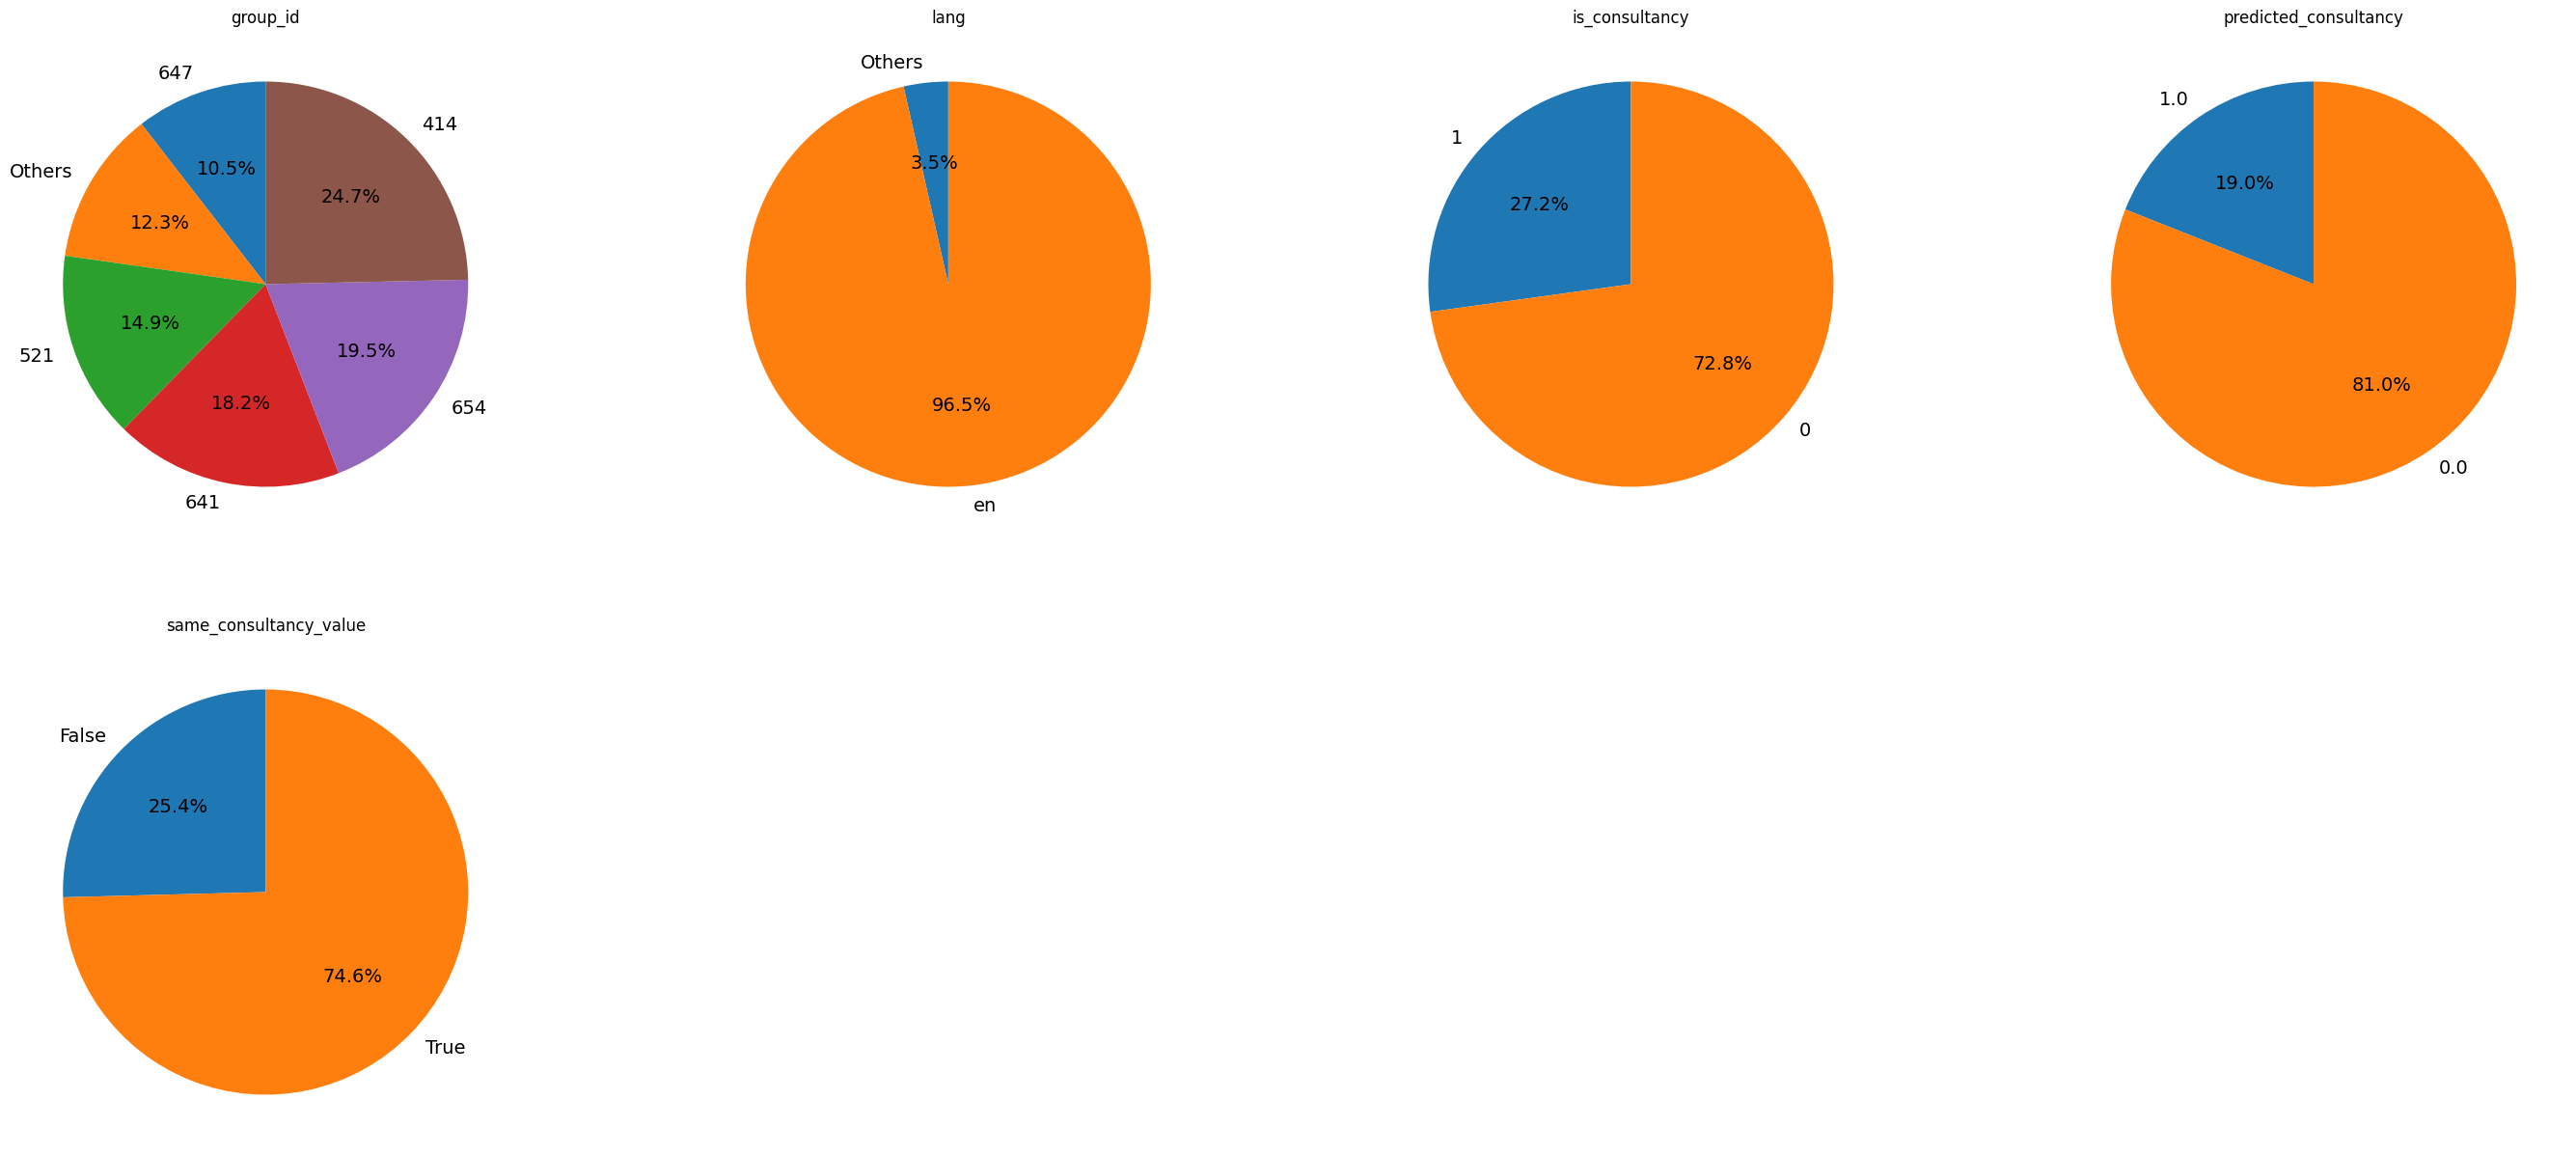

In [14]:
fig = plt.figure(figsize=(35, 15))

ax1 = fig.add_subplot(2, 4, 1)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'group_id', threshold=.05, ax=ax1)

ax2 = fig.add_subplot(2, 4, 2)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'lang', threshold=.01, ax=ax2)

ax3 = fig.add_subplot(2, 4, 3)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'is_consultancy', threshold=.01, ax=ax3)

ax4 = fig.add_subplot(2, 4, 4)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'predicted_consultancy', threshold=.01, ax=ax4)

ax5 = fig.add_subplot(2, 4, 5)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'same_consultancy_value', threshold=.01, ax=ax5)

#### Number of digits and punctuations at original texts

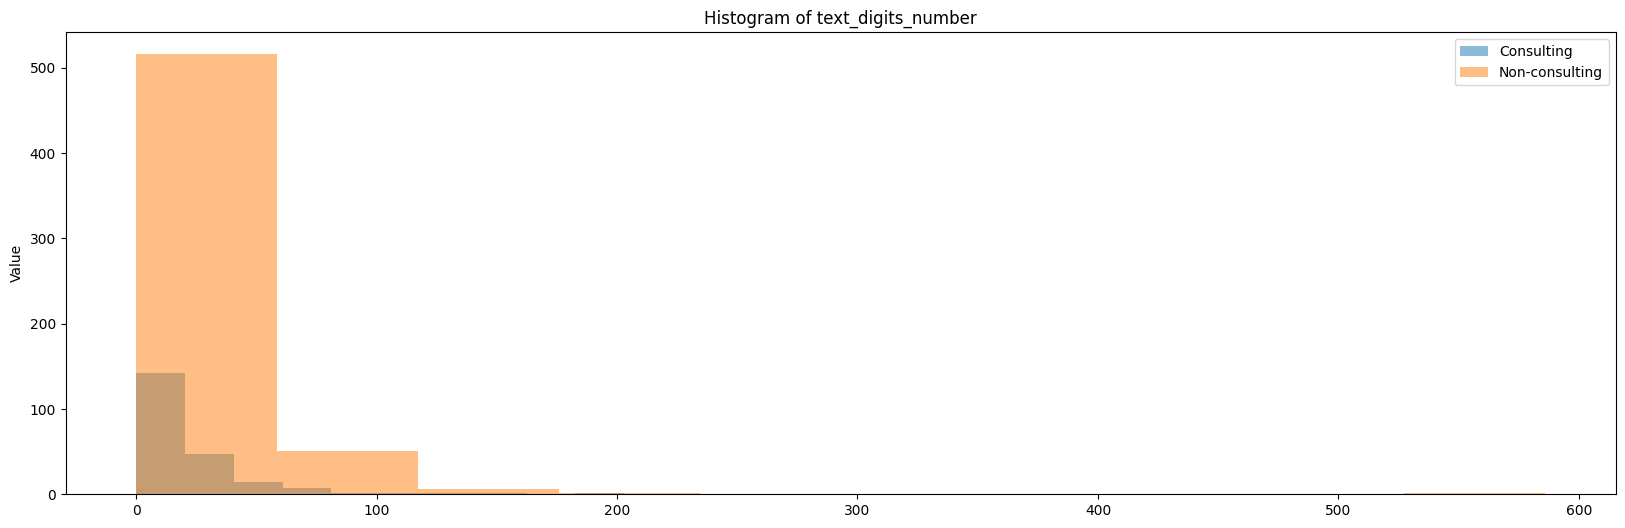

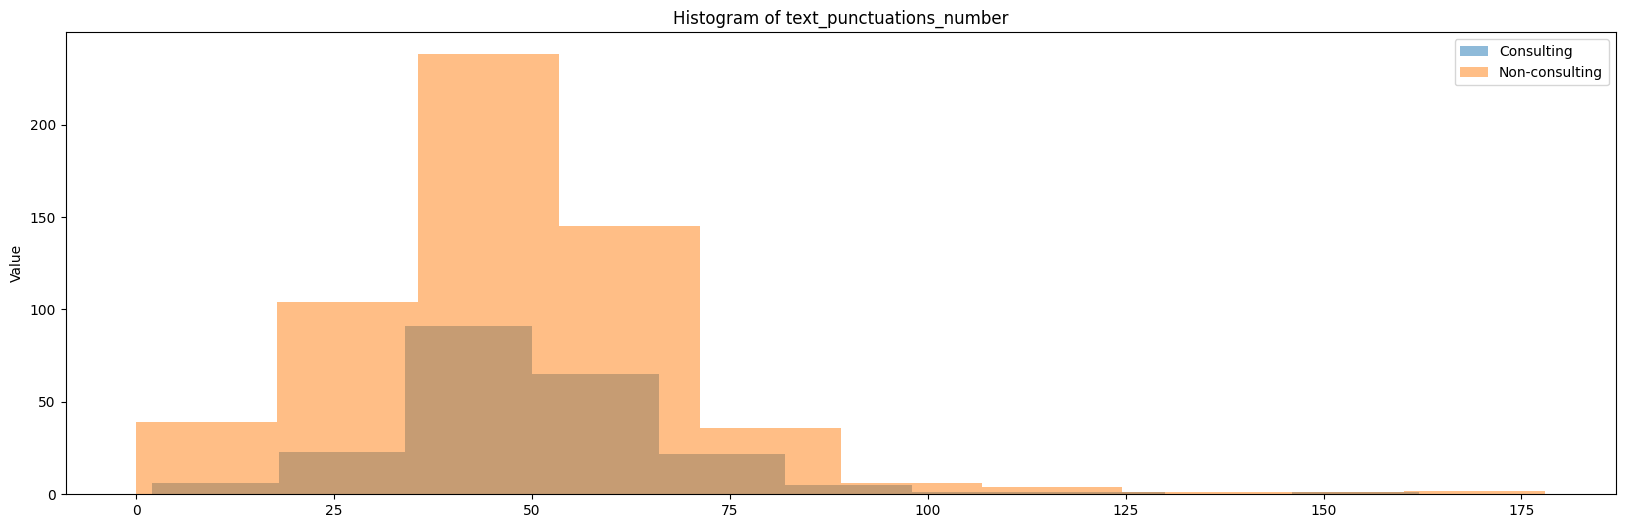

In [15]:
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_digits_number', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_punctuations_number', fig_size=(20, 6))

#### Text lenght histograms

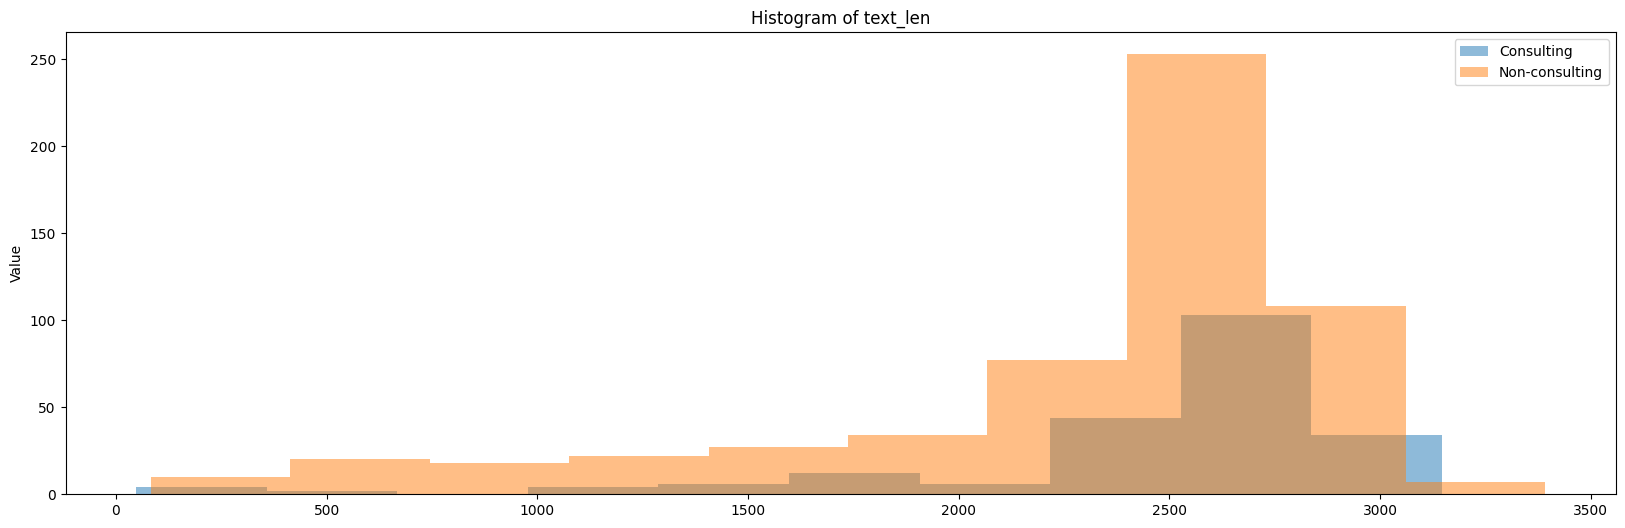

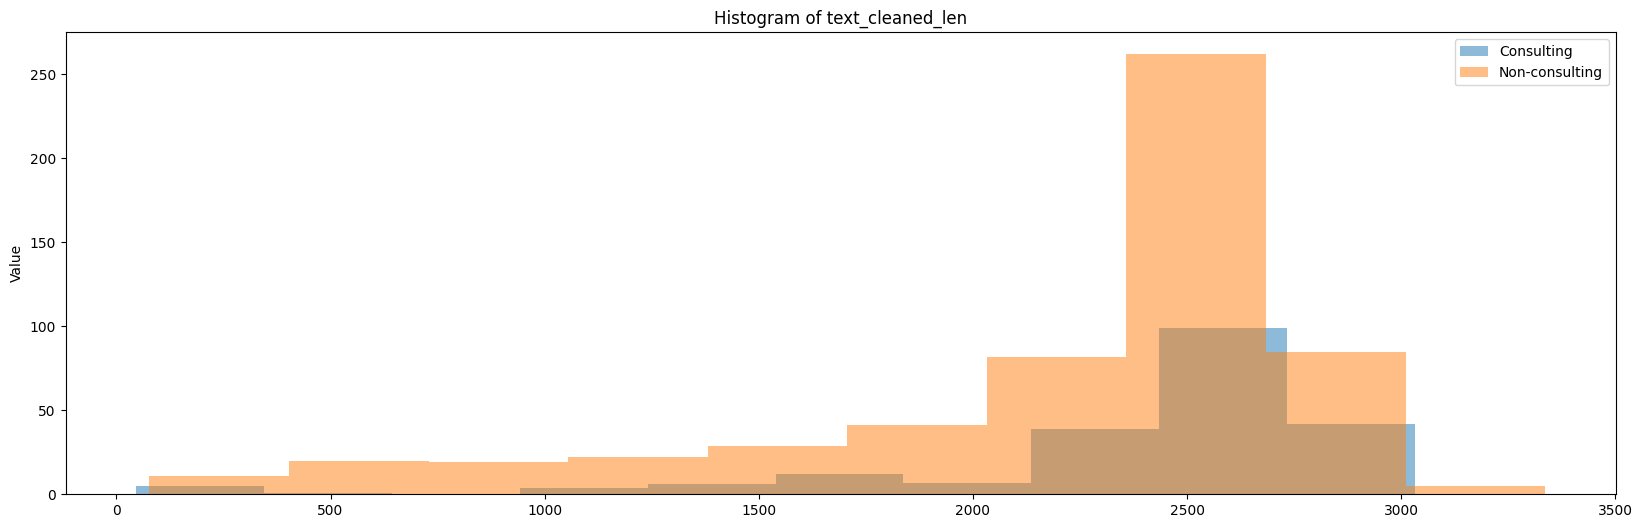

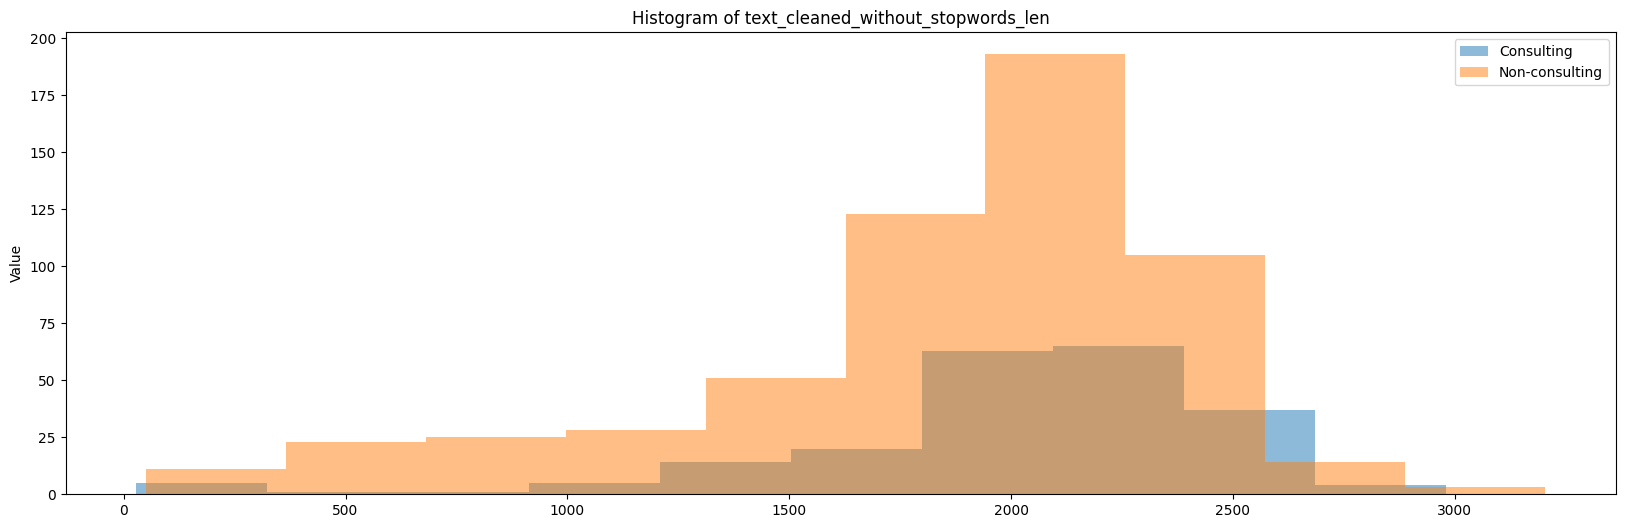

In [16]:
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_len', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_cleaned_len', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_cleaned_without_stopwords_len', fig_size=(20, 6))

#### Text lenght diff histograms

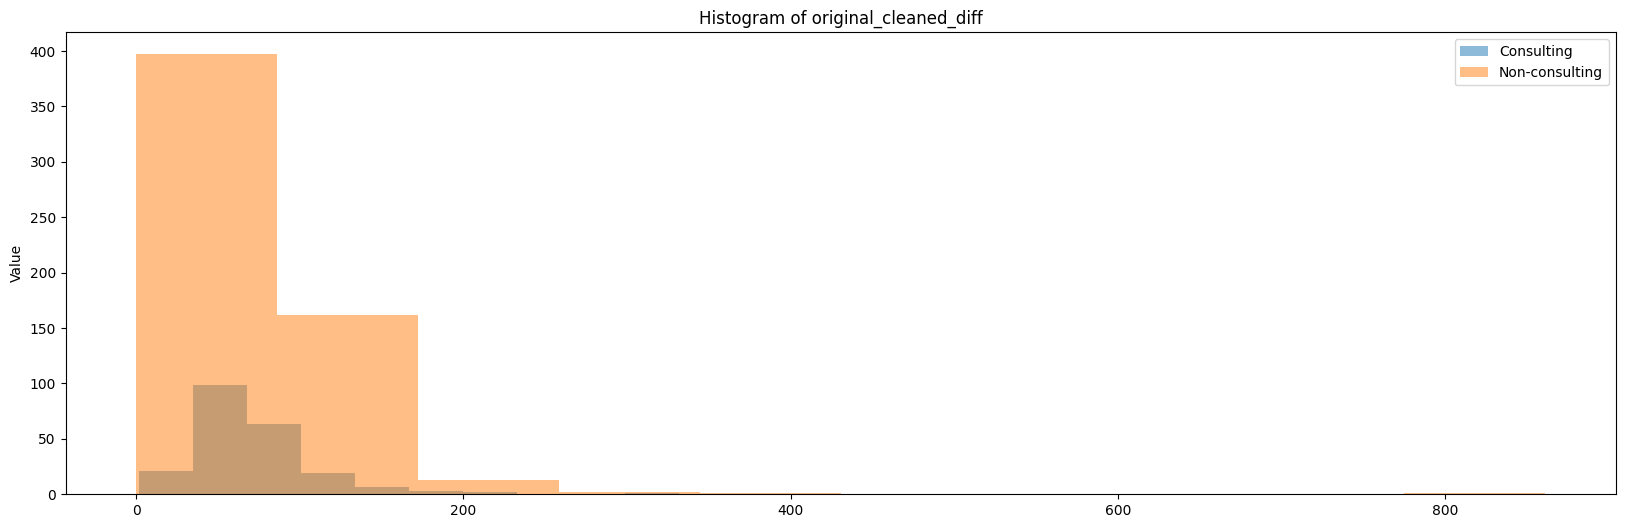

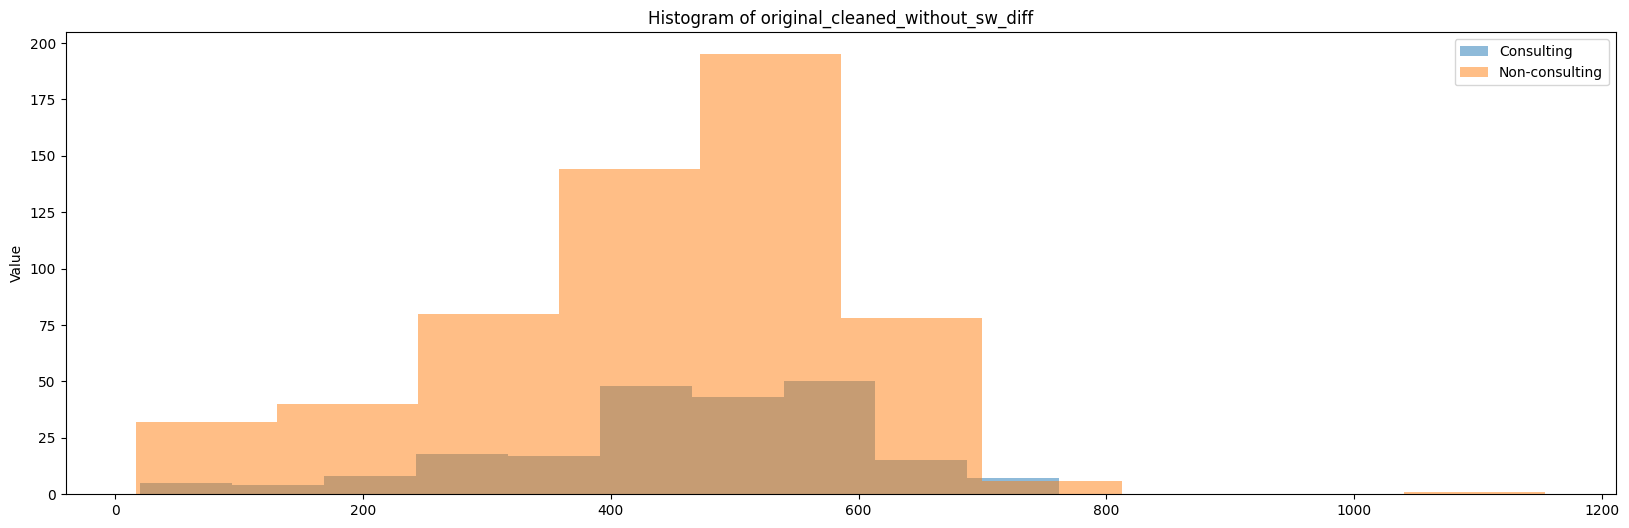

In [17]:
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'original_cleaned_diff', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'original_cleaned_without_sw_diff', fig_size=(20, 6))

#### Tokens number histograms

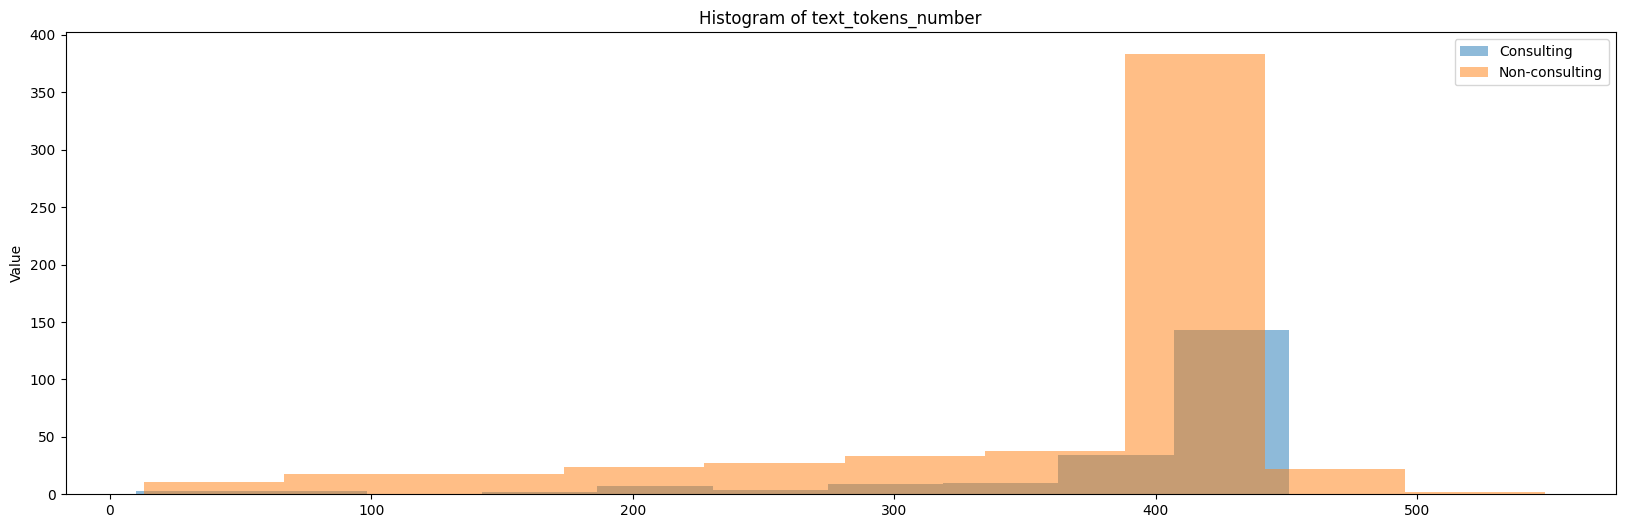

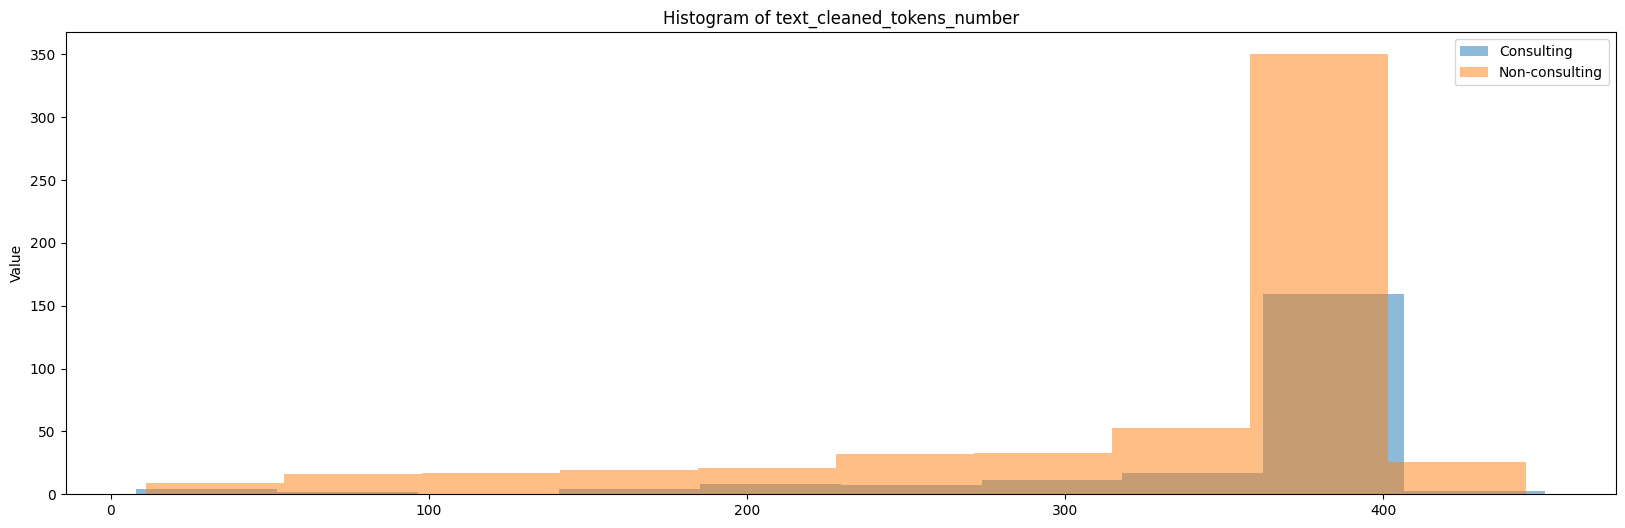

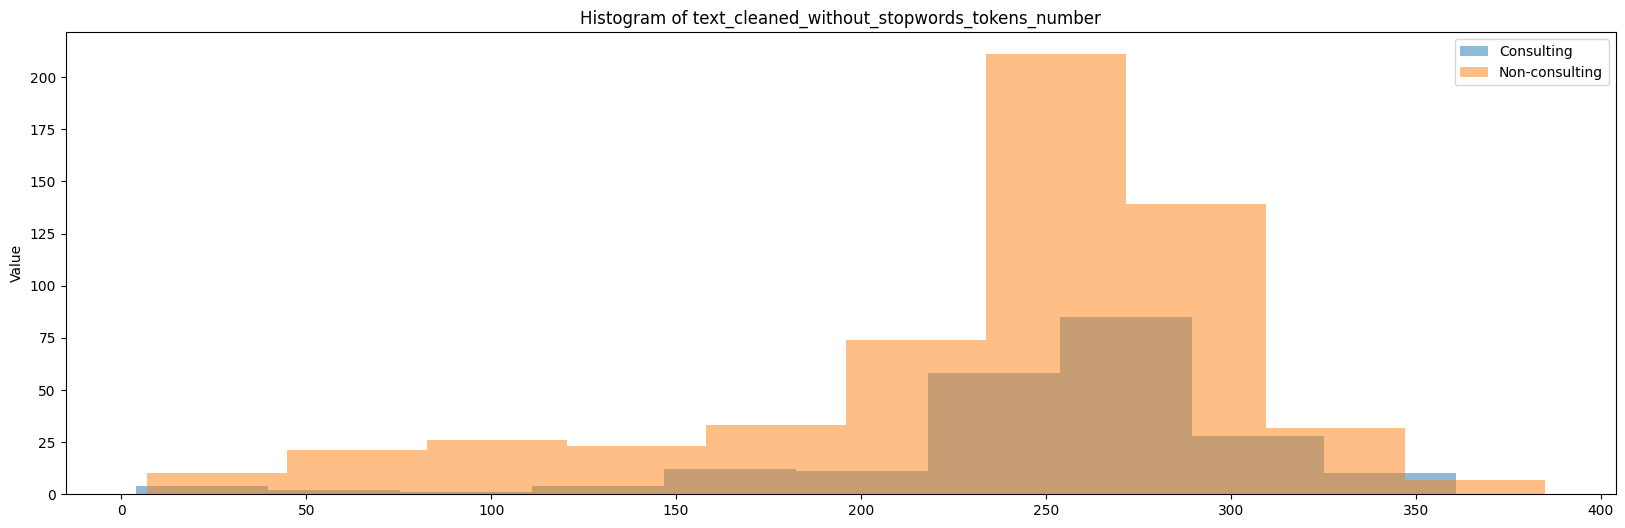

In [18]:
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_tokens_number', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_cleaned_tokens_number', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'text_cleaned_without_stopwords_tokens_number', 
    fig_size=(20, 6))

#### Tokens number diff histograms

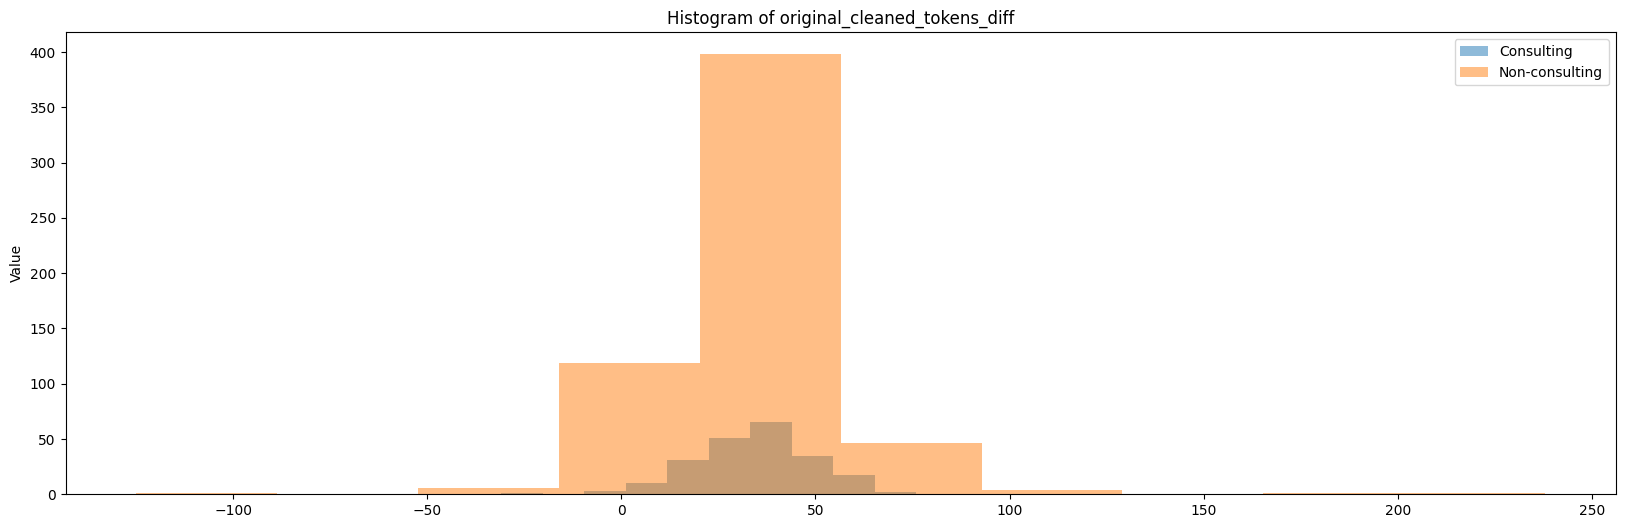

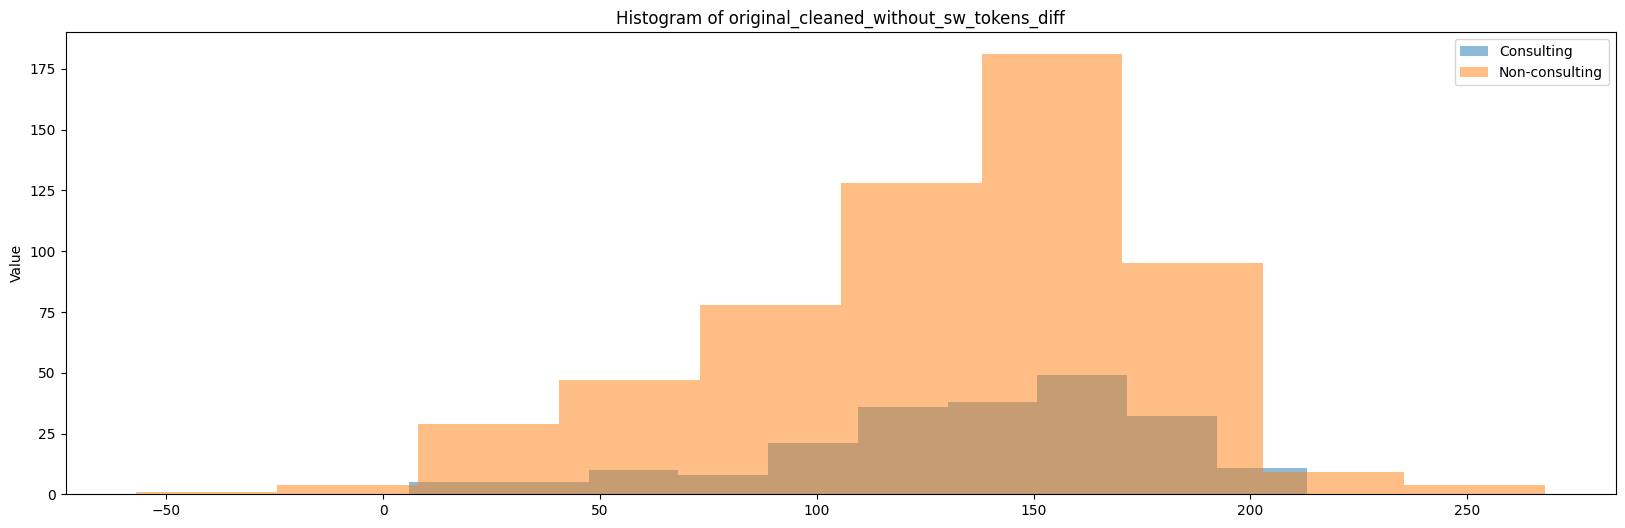

In [19]:
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'original_cleaned_tokens_diff', fig_size=(20, 6))
plot_data.create_consulting_non_consulting_histogram_plot(
    df, target_column, 'original_cleaned_without_sw_tokens_diff', fig_size=(20, 6))

#### Correlations

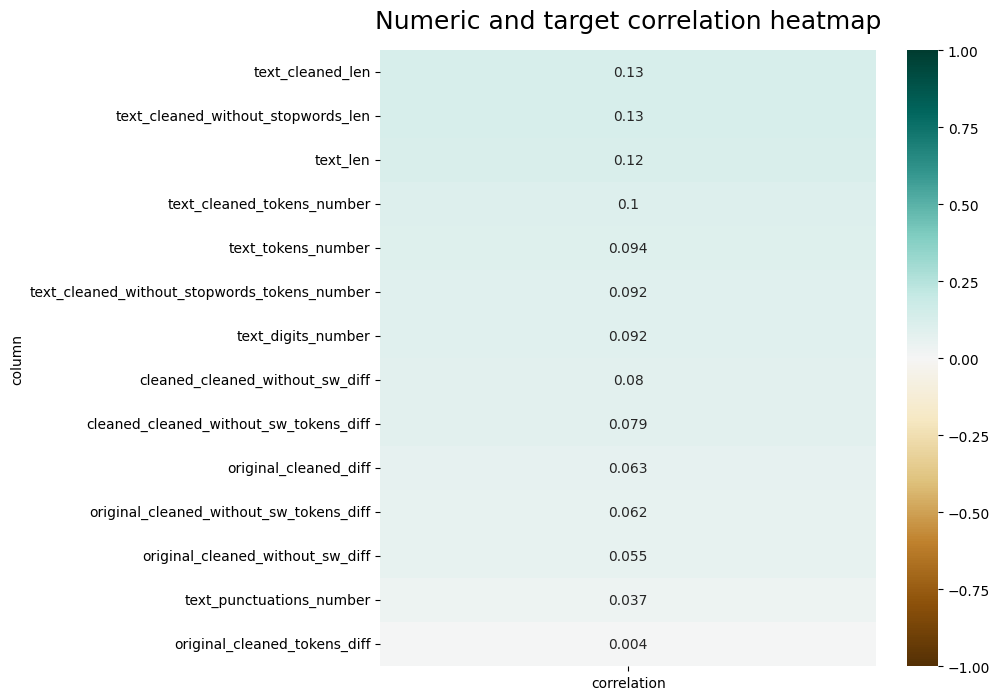

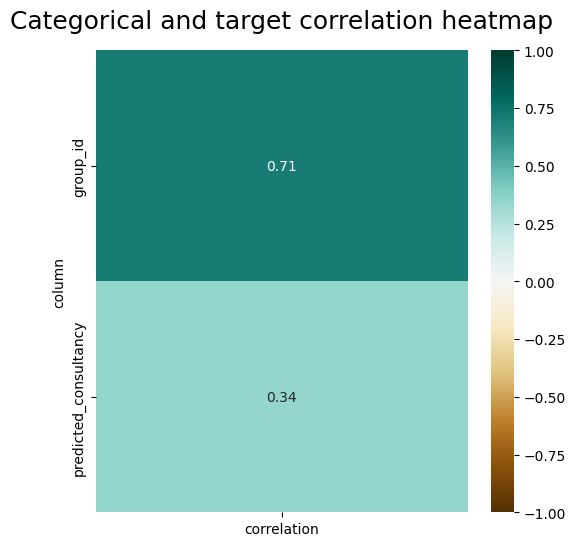

In [20]:
numeric_columns = [
    'text_digits_number',
    'text_punctuations_number', 'text_len', 'text_cleaned_len',
    'text_cleaned_without_stopwords_len', 'text_tokens_number',
    'text_cleaned_tokens_number',
    'text_cleaned_without_stopwords_tokens_number', 'original_cleaned_diff',
    'original_cleaned_without_sw_diff', 'cleaned_cleaned_without_sw_diff',
    'original_cleaned_tokens_diff',
    'original_cleaned_without_sw_tokens_diff',
    'cleaned_cleaned_without_sw_tokens_diff'
]

categorical_columns = [
    'group_id',
    'predicted_consultancy',
]
# Numercial vs categorical features correlations.
corr_df = tools_utils.compute_columns_correlation_with_target(
    df, numeric_columns, target_column, corr_method=correlation.compute_correlation_ratio)
plot_data.generate_heat_map(corr_df, 'Numeric and target correlation heatmap')

# Categorical vs categorical correlations.
corr_df = tools_utils.compute_columns_correlation_with_target(
    df, categorical_columns, target_column, corr_method=correlation.compute_cramers_v)
plot_data.generate_heat_map(
    corr_df, 'Categorical and target correlation heatmap', fig_size=(6, 6))

#### Languages per target

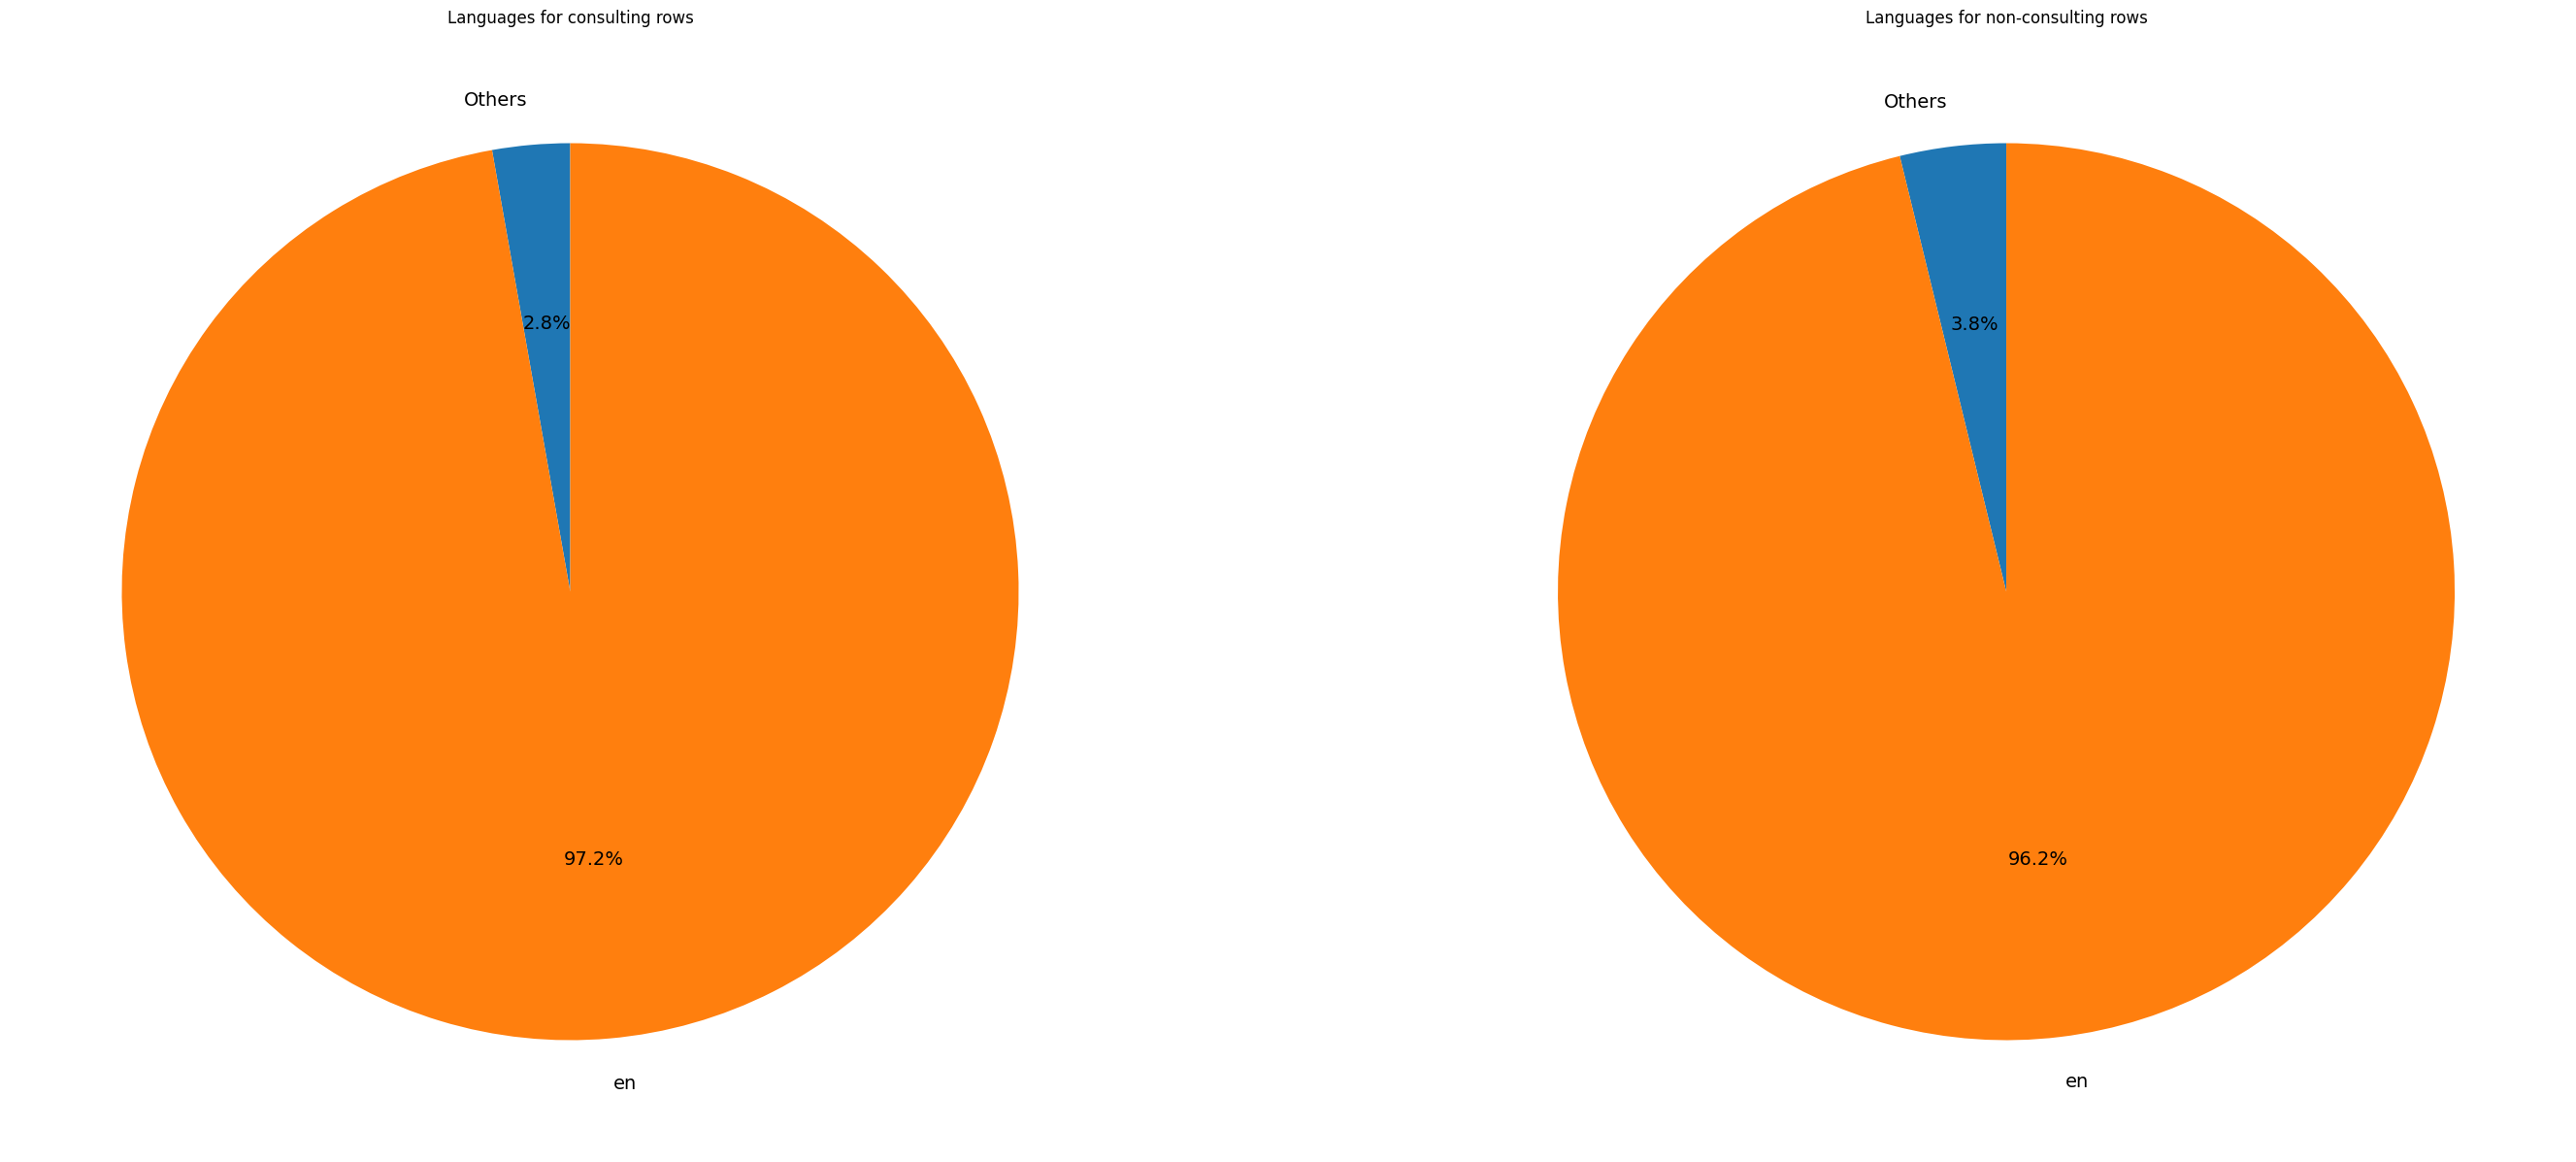

In [21]:
cond_is_consultancy = df[target_column] == 1

fig = plt.figure(figsize=(35, 15))

ax1 = fig.add_subplot(1, 2, 1)
plot_data.create_pie_chart_with_grouped_threshold(
    df[cond_is_consultancy], 'lang', threshold=.05, ax=ax1, 
    title='Languages for consulting rows')

ax2 = fig.add_subplot(1, 2, 2)
plot_data.create_pie_chart_with_grouped_threshold(
    df[~cond_is_consultancy], 'lang', threshold=.02, ax=ax2, 
    title='Languages for non-consulting rows')

In [37]:
df.lang.nunique()

12

In [38]:
df.lang.unique()

array(['en', 'de', 'fr', 'pt', 'it', 'es', 'da', 'nl', 'hu', 'sv', 'et',
       'fi'], dtype=object)

#### Wordcloud

In [22]:
texts = df.text_cleaned_without_stopwords.values.flatten()
consulting_text = df \
    .loc[cond_is_consultancy, 'text_cleaned_without_stopwords'] \
    .values.flatten()
non_consulting_text = df \
    .loc[~cond_is_consultancy, 'text_cleaned_without_stopwords'] \
    .values.flatten()

In [23]:
column = 'text_cleaned_without_stopwords_tokens'
text_corpus = [word for tokens in df[column].values for word in tokens]

is_consultancy_text_corpus = [
    word for tokens in df.loc[cond_is_consultancy, column].values
    for word in tokens]
non_consultancy_text_corpus = [
    word for tokens in df.loc[~cond_is_consultancy, column].values
    for word in tokens]

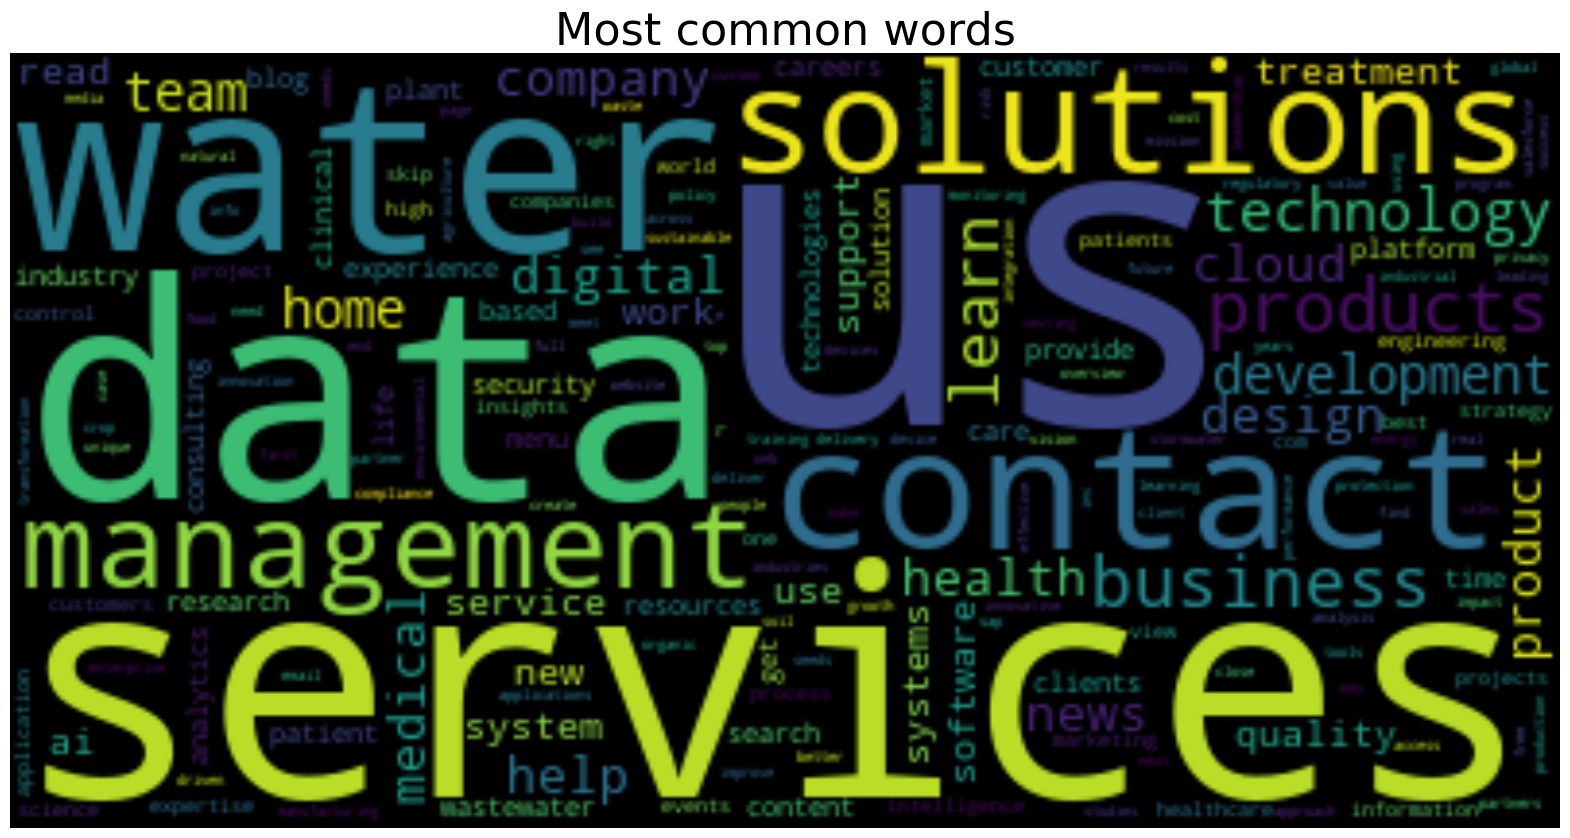

In [24]:
plot_data.generate_word_cloud(text_corpus, 'Most common words')

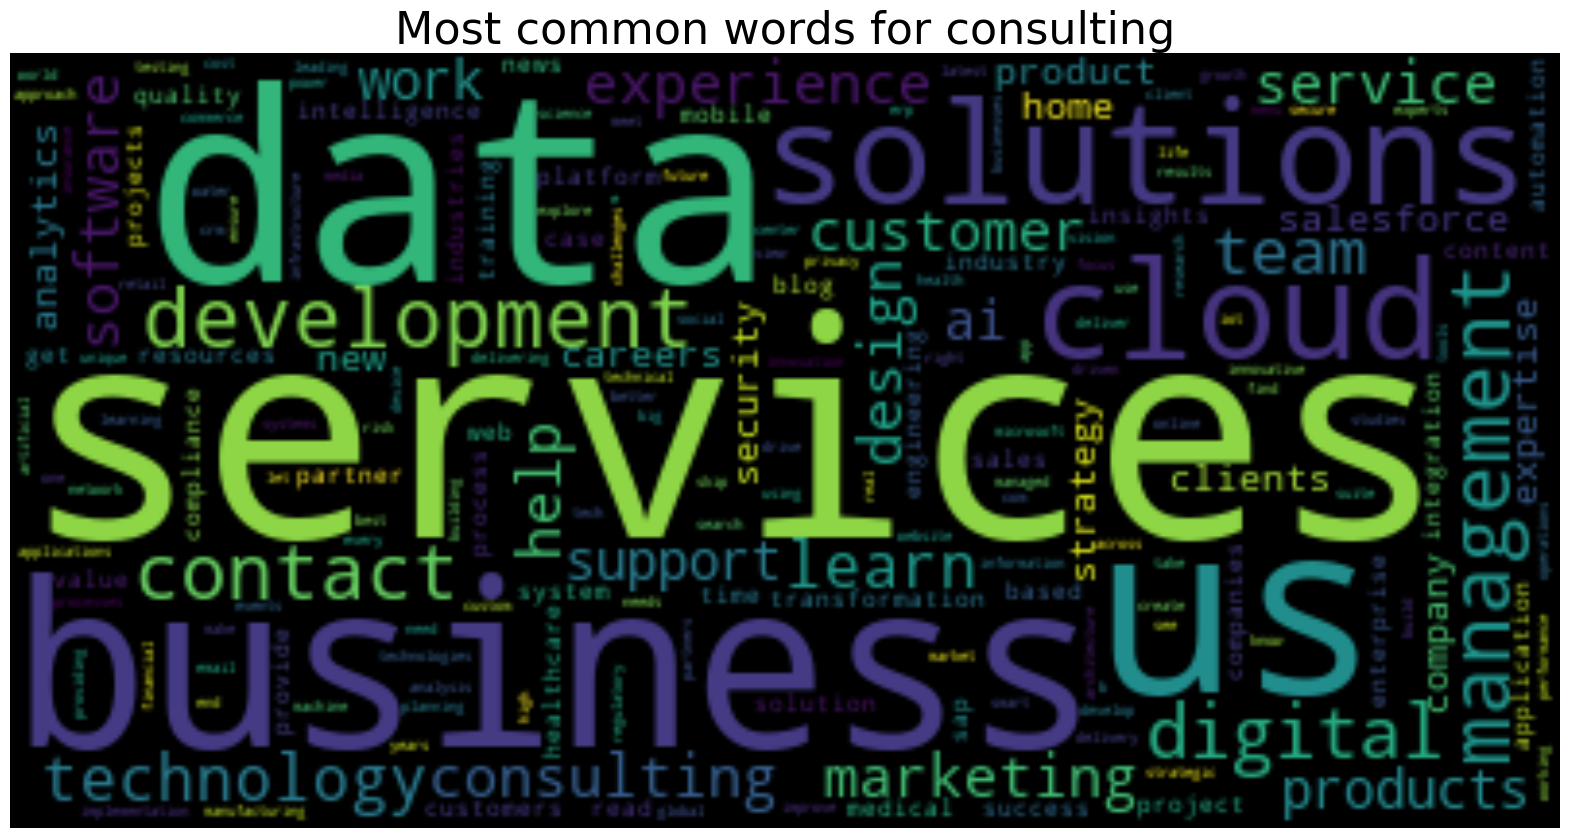

In [25]:
plot_data.generate_word_cloud(
    is_consultancy_text_corpus, 'Most common words for consulting')

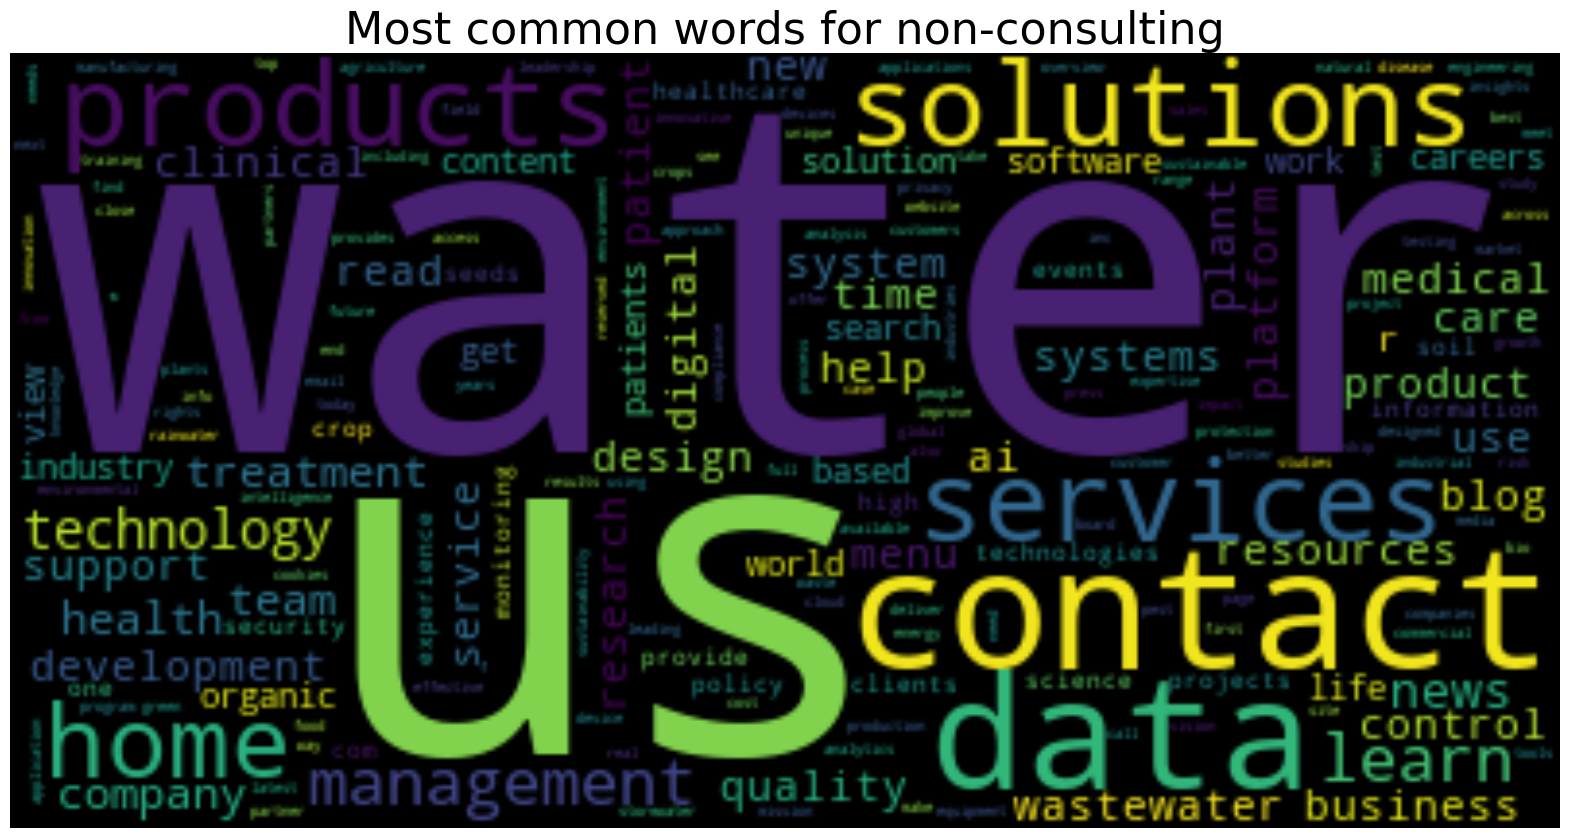

In [26]:
plot_data.generate_word_cloud(
    non_consultancy_text_corpus, 'Most common words for non-consulting')

#### Why 'water' is one of the most common word in non-consulting?

In [27]:
df['contains_water'] = df.text_cleaned_without_stopwords.str.contains('water')

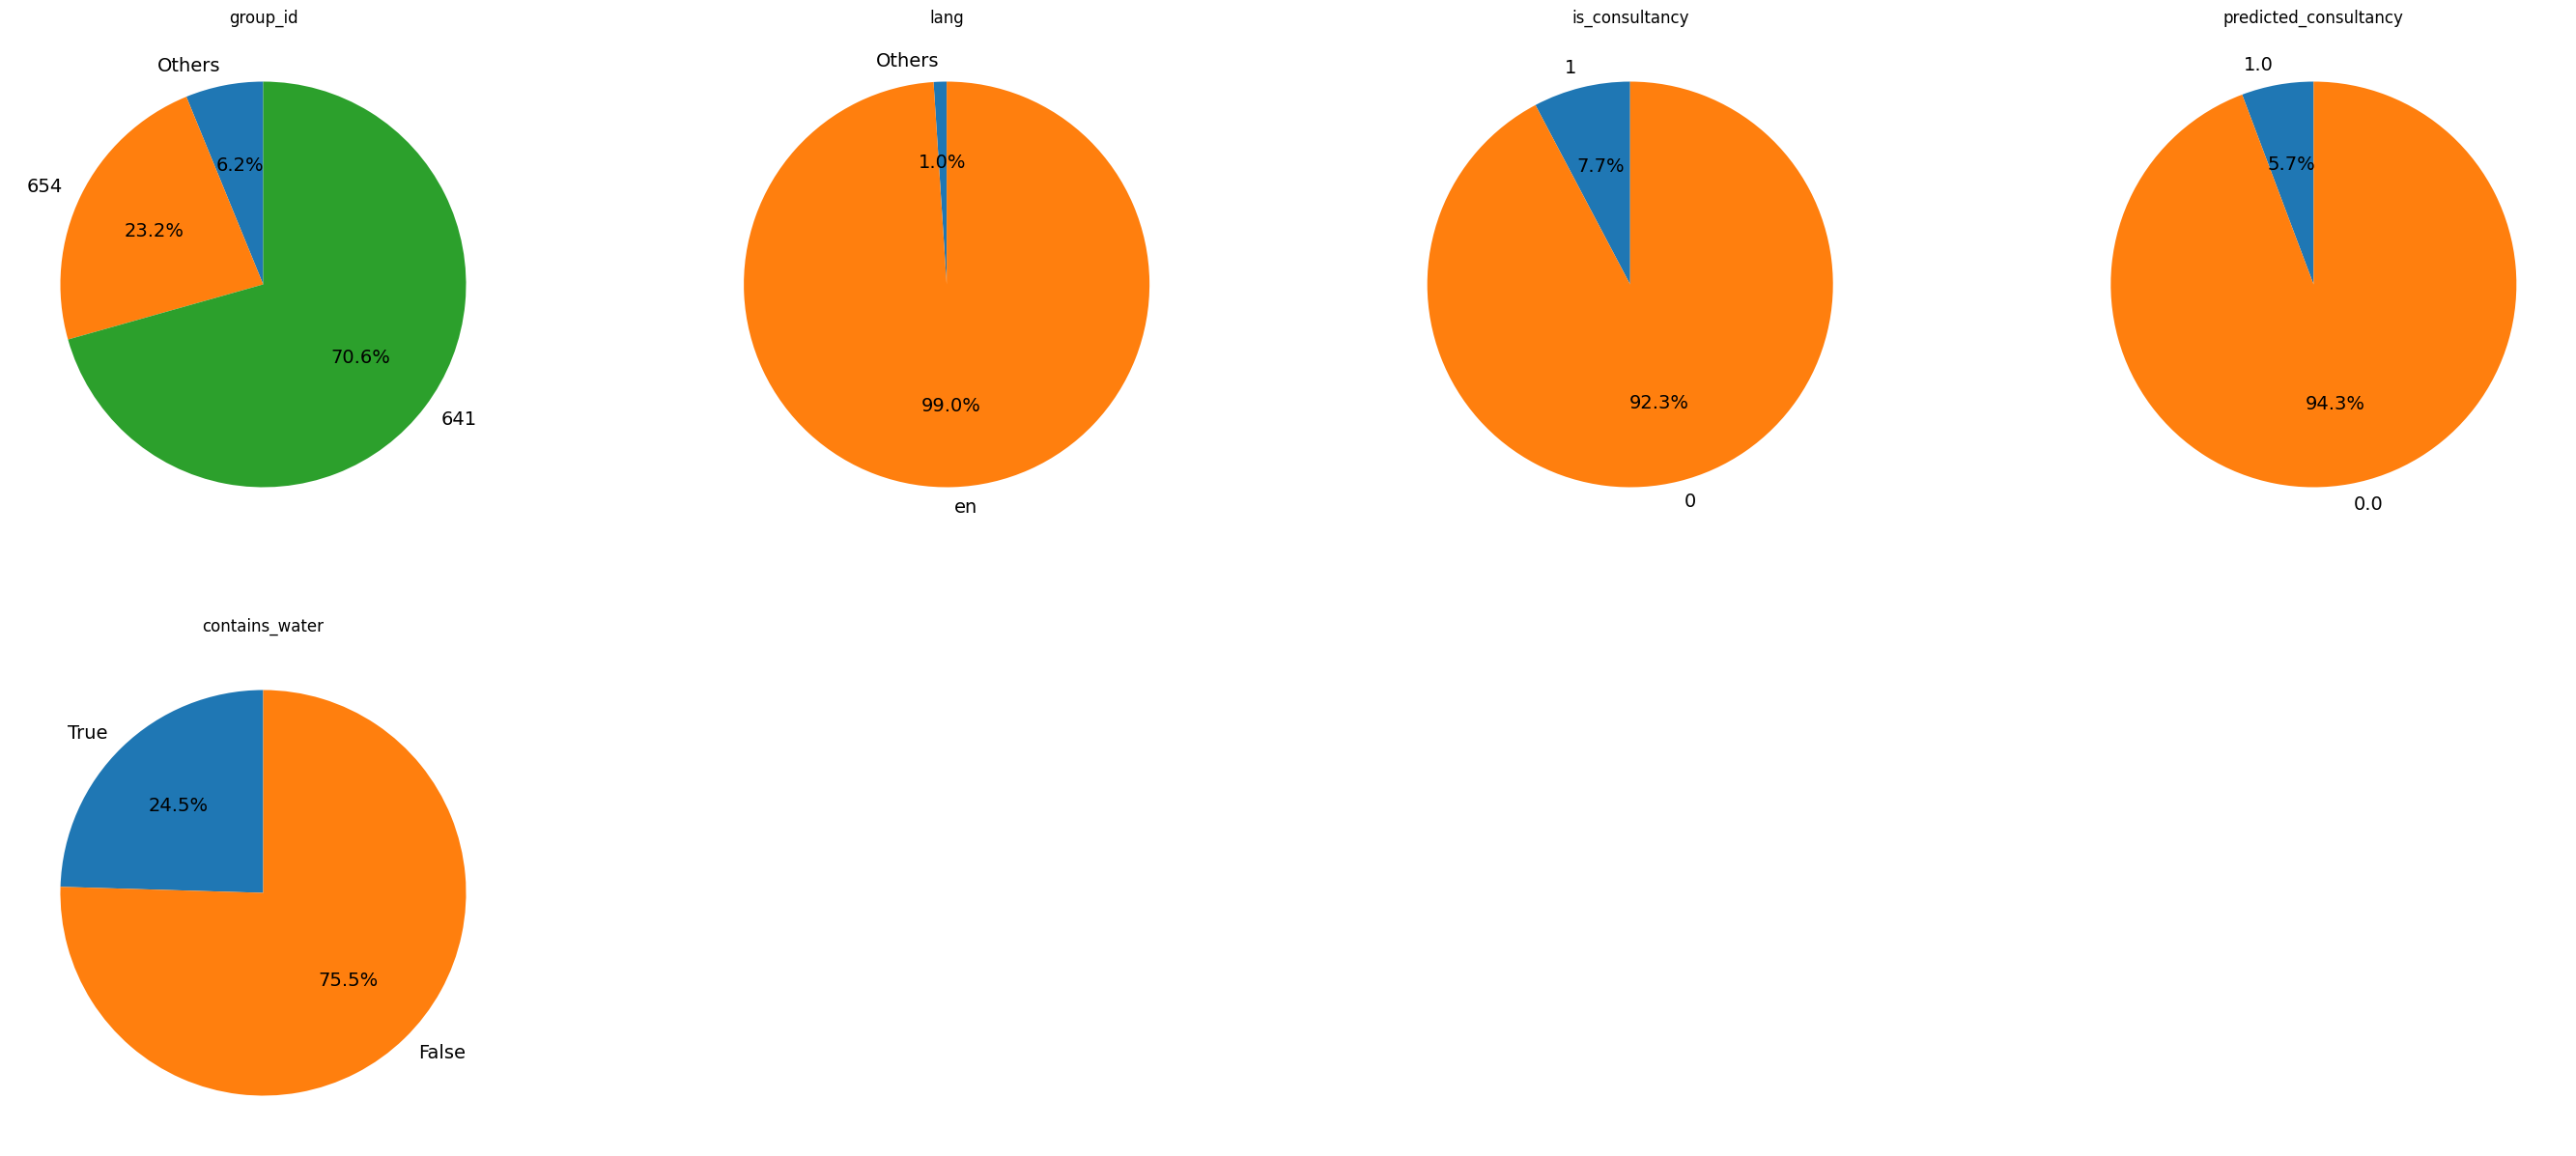

In [28]:
cond_contains_water = df['contains_water']

fig = plt.figure(figsize=(35, 15))

ax1 = fig.add_subplot(2, 4, 1)
plot_data.create_pie_chart_with_grouped_threshold(
    df[cond_contains_water], 'group_id', threshold=.05, ax=ax1)

ax2 = fig.add_subplot(2, 4, 2)
plot_data.create_pie_chart_with_grouped_threshold(
    df[cond_contains_water], 'lang', threshold=.01, ax=ax2)

ax3 = fig.add_subplot(2, 4, 3)
plot_data.create_pie_chart_with_grouped_threshold(
    df[cond_contains_water], 'is_consultancy', threshold=.01, ax=ax3)

ax4 = fig.add_subplot(2, 4, 4)
plot_data.create_pie_chart_with_grouped_threshold(
    df[cond_contains_water], 'predicted_consultancy', threshold=.01, ax=ax4)

ax5 = fig.add_subplot(2, 4, 5)
plot_data.create_pie_chart_with_grouped_threshold(
    df, 'contains_water', threshold=.01, ax=ax5)

#### Random samples that contains water

In [29]:
df[cond_contains_water].sample(n=1).text_cleaned.values[0]

'solutions meter data acquisition and management non revenue water products lte cellular devices set ami endpoints set remote smart valves software set head end system set customer portal set field mobile services installation and configuration data system integration training and support resources blog case studies webinars glossary product information company news about set careers contact us client login solutions meter data acquisition and management non revenue water products lte cellular devices set ami endpoints set remote smart valves software set head end system set customer portal set field mobile services installation and configuration data system integration training and support resources blog case studies webinars glossary product information company news about set careers contact us client login claritas est etiam processus dynamicus qui sequitur mutationem consuetudium lectorum eleifend option congue nihil imperdiet doming recent posts the first step september contact us

In [30]:
df[cond_contains_water].sample(n=1).text_cleaned.values[0]

'top of page home panels current panels regulatory advisory panels lott city of santa barbara experts diana aga phd michael anderson phd paul anderson phd charles b bott phd amy childress phd james crook phd jason dadakis pg chg glen daigger phd daniel gerrity phd scott fendorf phd ty ferr phd rick gersberg phd wendy graham phd chuck haas phd anya kaufmann pe emily marron phd mike mcguire phd tom missimer phd william mitch phd tyler nading pe mehul patel pe channah rock phd joan rose phd daniel schlenk phd matt simcik phd r scott summers phd george tchobanoglous phd sam upchurch phd steve via ms rick warner pe mike wehner mpa research fomc conference nwri fellowship program nwri fellows nwri fellows nwri fellows nwri fellows clarke prize clarke prize laureate past clarke prize laureates about board of directors people member agencies corporate associates contact subscribe privacy more use tab to navigate through the menu items nominations for the clarke prize are open click national wa

In [31]:
df[cond_contains_water].sample(n=1).text_cleaned.values[0]

'skip to main content reset social media find us this site requires javascript to be enabled otherwise some functions are not available and the page could not be navigable toggle navigation applications water resources management energy data management resource optimization d visualization environmental monitoring products wiski hydstra raster data service hydromaster soil moisture data service resopt dviewstation monitoring devices support company about kisters collaboration membership events news contact us contact form water resources management flexible scalable data management analytics for water professionals energy data management energy stream management from meter data to iso tso forecasting resource optimization identify the best rather than simulate options in complex systems d visualization powerful cad viewing analysis tools on your desktop or on the go environmental monitoring dataloggers tested in the most demanding conditions across the world previous next water resourc

### Generate the embeddings

#### Split texts into chunks of max sequence len

In [32]:
df['text_sequences'] = df.text_cleaned.apply(
    tools_utils.get_string_chunks, length=256)

selected_columns = [
    'company_id',
    'text_sequences',
]
contents_dict = df[selected_columns].to_dict('records')

In [33]:
text_embeddings = embedding.generate_average_embeddings_content(
    model_name, contents_dict, text='text_sequences', 
    content_id='company_id', embeddings_folder=embeddings_folder)

Computing embedding: 100%|██████████| 791/791 [00:00<00:00, 3371.88iter/s]


#### Configure Tensorboard

In [34]:
# Configure embeddings and metadata to show in Tensorboard 
checkpoint = tf.train.Checkpoint(
    embeddings=tf.Variable(text_embeddings, name='embeddings'),
)
checkpoint.save(checkpoint_embeddings)

# Create metadata
embedding.create_embeddings_metadata(
    df, metadata_columns, tensorboard_logs, 'metadata.tsv')

config = projector.ProjectorConfig()
embedding.add_embedding_to_projector_config(
    config, 'embeddings', 'metadata.tsv')
projector.visualize_embeddings(tensorboard_logs, config)

In [35]:
%load_ext tensorboard
%tensorboard --logdir /data/logs/

## Load

#### Save the dataset with features

In [36]:
df.drop(columns=['text_sequences']).to_csv(cleaned_dataset_filepath, index=False)